In [1]:
#!pip install torch torchaudio scikit-learn numpy
#!pip install soundfile

# IMPORT

In [2]:
import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.preprocessing.dataset import (
    list_ravdess_files,
    filter_audio_speech,
    RavdessDataset,
    extract_label_idx,
    IDX2LABEL,
)
from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



# DEFINIZIONE DATA BASE

In [3]:

set_seed(42)

DATA_ROOT = "./data"
EPOCHS = 90
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_ravdess_files(DATA_ROOT)
all_files = filter_audio_speech(all_files)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_label_idx(fp) for fp in all_files]
print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))


Device: cuda
Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})


# SPLIT DATASET

In [4]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU


In [5]:
from src.preprocessing.dataset import parse_ravdess_filename

def split_by_speakers(filepaths, train_speakers, val_speakers, test_speakers):
    train, val, test = [], [], []
    for fp in filepaths:
        actor = parse_ravdess_filename(fp)["actor"]
        if actor in train_speakers:
            train.append(fp)
        elif actor in val_speakers:
            val.append(fp)
        elif actor in test_speakers:
            test.append(fp)
    return train, val, test

In [6]:

# 3) split random stratificato (Phase 1: NON speaker-independent)
train_files, temp_files, train_y, temp_y = train_test_split(
   all_files, labels, test_size=0.30, random_state=42, stratify=labels
)
val_files, test_files, _, _ = train_test_split(
    temp_files, temp_y, test_size=0.50, random_state=42, stratify=temp_y
)

print(f"Split -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# Speaker-independent split (attori disgiunti)
#train_spk = [f"{i:02d}" for i in range(1, 17)]   # 01..18
#val_spk   = [f"{i:02d}" for i in range(17, 21)]  # 19..22
#test_spk  = [f"{i:02d}" for i in range(21, 25)]  # 23..24

#train_files, val_files, test_files = split_by_speakers(all_files, train_spk, val_spk, test_spk)

#print(f"Split SI -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

from collections import Counter
import torch

train_labels = [extract_label_idx(fp) for fp in train_files]
counts = Counter(train_labels)

weights = torch.tensor([1.0 / counts[i] for i in range(8)], dtype=torch.float, device=device)
weights = weights / weights.sum() * 8  # normalizzazione

print("Class counts:", counts)
print("Weights:", weights.detach().cpu().numpy())

# 4) dataset + loader
AUG_ON = True  # <-- switch globale (metti False per disattivare tutto)

aug_cfg = {
    "gain": True,
    "gain_db": (-3, 3),

    "time_shift": True,
    "time_shift_s": 0.03,   

    "noise": True,
    "snr_db": (25, 40),  
    "vtlp": False,   

    "reverb": True,
    "reverb_ir_s": 0.04,
    "reverb_decay": 0.25,
}


train_ds = RavdessDataset(train_files, augmentation=AUG_ON, aug_config=aug_cfg)
val_ds   = RavdessDataset(val_files,   augmentation=False)   # NO augmentation su val
test_ds  = RavdessDataset(test_files,  augmentation=False)   # NO augmentation su test

# num_workers=0: più stabile su Windows/CPU (evita crash dei processi worker)
# pin_memory=False: utile solo con GPU (CUDA), su CPU non porta vantaggi
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# 5) model
model = CRNN(n_classes=8, n_mels=64).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=6)

best_val_acc = 0.0
best_path = "best_phase1.pt"

# HISTORY PER GRAFICO 
val_acc_hist = []
test_acc_hist = []


Split -> train 1008 | val 216 | test 216
Class counts: Counter({6: 135, 1: 135, 2: 135, 4: 134, 7: 134, 3: 134, 5: 134, 0: 67})
Weights: [1.7821782  0.88448846 0.88448846 0.8910891  0.8910891  0.8910891
 0.88448846 0.8910891 ]


c:\Users\eleon\mnist_env_gpu_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [7]:

# 6) training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = torch.nn.functional.cross_entropy(logits, y, weight=weights, label_smoothing=0.1)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    val_loss, val_acc = evaluate(model, val_loader, device)
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)  # <-- test ogni epoca

    scheduler.step(val_acc)

    # salva history
    val_acc_hist.append(val_acc)
    test_acc_hist.append(test_acc_epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"test acc {test_acc_epoch:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1/90 | train loss 2.0937 acc 0.1200 | val loss 2.0570 acc 0.2639 | test acc 0.2269
Epoch 2/90 | train loss 2.0641 acc 0.1587 | val loss 2.0016 acc 0.2639 | test acc 0.2500
Epoch 3/90 | train loss 2.0164 acc 0.2361 | val loss 1.9585 acc 0.2407 | test acc 0.1944
Epoch 4/90 | train loss 1.9550 acc 0.2381 | val loss 1.8074 acc 0.3704 | test acc 0.3287
Epoch 5/90 | train loss 1.9272 acc 0.2659 | val loss 1.8123 acc 0.3241 | test acc 0.2731
Epoch 6/90 | train loss 1.8918 acc 0.2877 | val loss 1.7940 acc 0.3380 | test acc 0.3102
Epoch 7/90 | train loss 1.8345 acc 0.3244 | val loss 1.7658 acc 0.3380 | test acc 0.3565
Epoch 8/90 | train loss 1.8076 acc 0.3254 | val loss 1.6890 acc 0.3981 | test acc 0.3704
Epoch 9/90 | train loss 1.7797 acc 0.3472 | val loss 1.6968 acc 0.3565 | test acc 0.3935
Epoch 10/90 | train loss 1.7671 acc 0.3442 | val loss 1.6295 acc 0.4213 | test acc 0.3750
Epoch 11/90 | train loss 1.7427 acc 0.3869 | val loss 1.5864 acc 0.3981 | test acc 0.3981
Epoch 12/90 | train

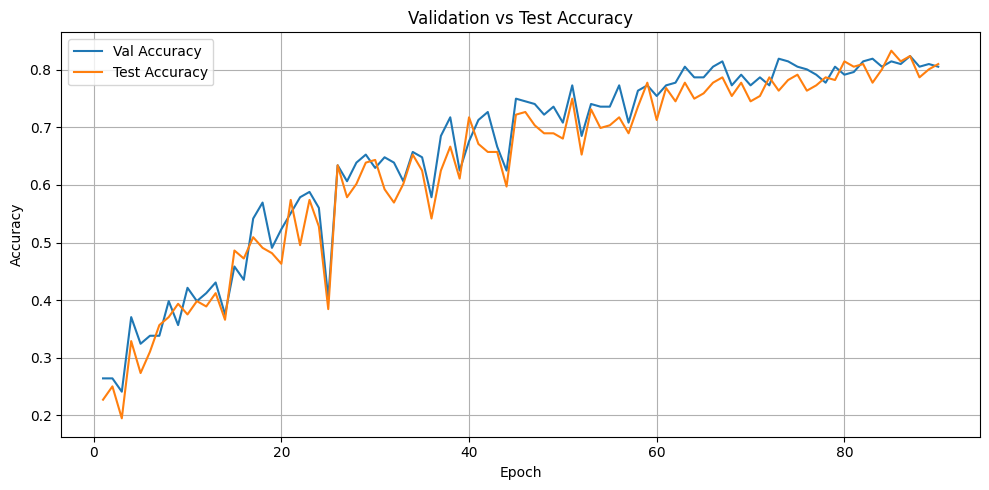


Best val acc: 0.8240740740740741
TEST (best checkpoint) | loss 0.5875 acc 0.8241

Classification report:
              precision    recall  f1-score   support

     neutral     0.5000    0.8571    0.6316        14
        calm     0.8387    0.9286    0.8814        28
       happy     0.9091    0.6897    0.7843        29
         sad     0.7600    0.6552    0.7037        29
       angry     0.8571    0.8276    0.8421        29
     fearful     0.8000    0.9655    0.8750        29
     disgust     0.9231    0.8276    0.8727        29
   surprised     1.0000    0.8621    0.9259        29

    accuracy                         0.8241       216
   macro avg     0.8235    0.8267    0.8146       216
weighted avg     0.8459    0.8241    0.8270       216

Confusion matrix:
[[12  1  1  0  0  0  0  0]
 [ 1 26  0  1  0  0  0  0]
 [ 4  1 20  0  1  3  0  0]
 [ 4  3  0 19  0  3  0  0]
 [ 2  0  1  0 24  0  2  0]
 [ 0  0  0  1  0 28  0  0]
 [ 1  0  0  2  2  0 24  0]
 [ 0  0  0  2  1  1  0 25]]


In [8]:

# Grafico accuracy train vs val
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")

# 8) report dettagliato
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1).numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())

print("\nClassification report:")
target_names = [IDX2LABEL[i] for i in range(8)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
